# DL 复习

## 目录

## Lect 2 线性回归，二分类回归，损失函数

### 线性回归


- 在线性回归中， 如果假定误差是正态，极大似然可以推导出OLS，即MSE准则
- 若假定误差是Laplace分布，极大似然可以推导出MAE准则

### 线性二分类

$$Y|x \sim Bernoulli(\rho(\beta'x))$$


- $\rho(\beta'x)$把$\beta'x$映射到$(0,1)$，表示$Y=1$的概率
- 当$\rho(x)=e^x/(e^x+1)$时，称为logistic 回归

***Lositics 回归***
- 损失函数
  $$\begin{aligned} 
  L(\beta)&=n^{-1}\sum_{i=1}^n l(\rho(\beta'x_i),y_i) 
  \\
  &= n^{-1}\sum_{i=1}^n \left[ y_i\log \rho(\beta'x_i) + (1-y_i)\log(1-\rho(\beta'x_i)) \right]
  \end{aligned}$$


In [1]:
# logistics MLE loss function

def loss_fn_logistic(bhat, x, y):
    rhohat = sigmoid(torch.matmul(x,bhat))
    loss = -torch.sum(y*torch.log(rhohat) + (1-y) * torch.log(1-rhohat))/y.shape[0]
    return loss

### 其他损失函数

- KL 散度
- 最小化KL散度等价于MLE

## Lect 3 Pytorch 基础、线性多分类

### PyTorch 基本操作

基本数据操作

In [2]:
import numpy as np
import torch

# 随机数种子
np.random.seed(123456)
torch.manual_seed(123456)

# 创建向量/矩阵
vec = torch.tensor([1.0, 2.0, 5.0])
print(vec)
mat = torch.tensor([[1.0, 2.0, 2.0], [3.0, 5.0, 4.5]])
print(mat)

# 特殊向量
torch.ones(3, 2)
torch.zeros(5)
torch.linspace(3, 10, steps=5)
torch.randn(2, 3)

# 矩阵形状与变形
print(vec.shape)
print(mat.shape)
n = mat.shape[0]
p = mat.shape[1]

print(vec.view(3, 1))
print(mat.view(3, 2))

# 汇总
print(mat)
print(torch.sum(mat, dim=0))
print(torch.sum(mat, dim=1))

# 矩阵计算
torch.matmul(torch.t(mat), mat)
mat.t()

tensor([1., 2., 5.])
tensor([[1.0000, 2.0000, 2.0000],
        [3.0000, 5.0000, 4.5000]])
torch.Size([3])
torch.Size([2, 3])
tensor([[1.],
        [2.],
        [5.]])
tensor([[1.0000, 2.0000],
        [2.0000, 3.0000],
        [5.0000, 4.5000]])
tensor([[1.0000, 2.0000, 2.0000],
        [3.0000, 5.0000, 4.5000]])
tensor([4.0000, 7.0000, 6.5000])
tensor([ 5.0000, 12.5000])


tensor([[1.0000, 3.0000],
        [2.0000, 5.0000],
        [2.0000, 4.5000]])

统计分布

In [3]:
import torch.distributions as D
import math

# 正态分布【注意，scale传入标准差】
## 生成分布形式
norm = D.Normal(loc=torch.tensor([1.0]), scale=torch.tensor([math.sqrt(3.0)]))
## 求正态分布某点对数密度函数
norm.log_prob(torch.tensor([1.0, 2.0, 3.0]))
## 生成正态随机数
norm.sample(sample_shape=(5,))

# Bernoulli分布
## 可以同时指定多组Bernoulli分布
bern = D.Bernoulli(probs=torch.tensor([0.1, 0.5, 0.9]))
bern.sample()

tensor([0., 1., 1.])

其他常见的操作可以参考[官方教程](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)，完整的函数列表可以查看[官方 API 文档](https://pytorch.org/docs/stable/torch.html)。

例Ex：计算 $d$ 维标准正态分布的对数密度函数 $\log[p_Z(z)]$，其中

$$p_{Z}(z)=(2\pi)^{-d/2}\exp\left(-\frac{1}{2}\Vert z\Vert^{2}\right).$$

其中$z \in \mathbb{R}^{n\times d}$, $l \in \mathbb{R}^{n\times l}$, `l` 的第 $i$ 个元素是 $\log[p_Z(\cdot)]$ 在 `z` 的第 $i$ 行上的取值


In [4]:
def log_normal_pdf(z):
    Norm = torch.norm(z,dim=1)
    d = z.size()[1]
    pz = (2*math.pi)**(-d/2)*torch.exp(-1/2*Norm**2)
    l = torch.log(pz)
    return l

# pytorch: torch.logaddexp(x, y)

### 线性多分类

$$Y|x \sim Multinomial(\rho(Wx))$$

- $x_i \in \mathbb{R}^p$: 每个obs的数据包括p个特征
- $y_i \in \mathbb{R}^k$: 每个obs的数据包括k个类别，且此处是one-hot编码，即$y_i$只有一个元素为1，其余为0
- $W \in \mathbb{R}^{k \times p}$: 负责将$p$维的特征映射到$k$维的类别
- $\rho(Wx)$: 将$Wx$映射到$(0,1)^k$，表示每个类别的概率

***Softmax 回归***
- 当取$\rho(Wx)=\frac{e^{Wx}}{\sum_{j=1}^k e^{Wx_j}}$时，称为Softmax回归
- 多项函数的对数似然为：$l(p;y) = \sum_{j=1}^k y_j \log p_j$, 其中$p = (p_1,\dots,p_k) = \rho(Wx)$
- 损失函数为：$L(W) = n^{-1} \sum_{i=1}^n l(\rho(Wx_i);Y_i)$

线性多分类完整作业习题

In [5]:
import numpy as np
import torch
import torch.distributions as D
import math
import torch.nn as nn

# 模拟生成数据X、标签l，one-hot编码
np.random.seed(123456)
torch.manual_seed(123456)

n = 200  # 样本量
p = 10   # 变量数
k = 4    # 类别数
x = torch.randn(n, p)
l = torch.tensor(np.random.choice(range(4), size=n, replace=True), dtype=int)
print(l[:20])

y = torch.nn.functional.one_hot(l)
print(y.shape)
print(y[:10])

# 模拟矩阵W
norm = D.Normal(loc=torch.tensor([1.0]), scale=torch.tensor([math.sqrt(1.0)]))
w = norm.sample(sample_shape=(k,p)).view(k,p) #?

# p = softmax(Wx)
u = torch.matmul(x, w.t())
assert u.shape == (n, k), "u 形状有误"
p  = torch.softmax( u, dim = 1 )
assert p.shape == (n, k), "p 形状有误"

# 编写损失函数
def loss_fn_softmax(w, x, y):
    rho = torch.softmax(torch.matmul(x,w.t()),dim=1)
    l = torch.sum(torch.log(rho)*y)/y.shape[0]
    return - l
loss2 = loss_fn_softmax(w, x, y)
print(loss2)

# 与现成函数CrossEntropyLoss()
ce_softmax = nn.CrossEntropyLoss()
loss1 = ce_softmax(u, l)
print(loss1)

tensor([1, 2, 2, 1, 0, 3, 3, 3, 3, 0, 3, 0, 0, 2, 2, 0, 3, 0, 3, 3])
torch.Size([200, 4])
tensor([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [1, 0, 0, 0]])
tensor(3.3032)
tensor(3.3032)


## Lect4 前馈神经网络(数值稳定)、反向传播

#### 激活函数

![](https://michael-1313341240.cos.ap-shanghai.myqcloud.com/202312261301460.png)


#### 数值稳定

***Sigmoid***

$\exp(x)$当$x$过大时发生溢出。可以上下同除以$\exp(x)$得到：
$$ \sigma(x) = \frac{1}{1+\exp(-x)}$$

In [6]:
def sigmoid2(x):
    sig  = 1 / ( 1 + torch.exp(-x) )
    return sig
# PyTorch 自带函数
print(torch.sigmoid(x))

tensor([[0.2457, 0.1365, 0.7361,  ..., 0.5106, 0.5940, 0.5134],
        [0.6236, 0.3778, 0.3801,  ..., 0.4742, 0.5296, 0.4320],
        [0.7602, 0.8008, 0.7452,  ..., 0.6917, 0.5353, 0.3651],
        ...,
        [0.5429, 0.1368, 0.7679,  ..., 0.5520, 0.3152, 0.7340],
        [0.2388, 0.4695, 0.4343,  ..., 0.0747, 0.6731, 0.3631],
        [0.6627, 0.3355, 0.2810,  ..., 0.7246, 0.3699, 0.2867]])


***tanh***

当 $x>>0$时，分子$e^x$会发生溢出。可以上下同乘以$\exp(-x)$得到：
$$ \sigma(x) = \frac{1-\exp(-2x)}{1+\exp(-2x)}$$
当 $x<<0$时，分母$e^{-x}$会发生溢出。可以上下同乘以$\exp(x)$得到：
$$ \sigma(x) = \frac{\exp(2x)-1}{\exp(2x)+1}$$

In [7]:
def tanh2(x):
    exp = torch.exp( -2 * torch.abs(x) ) # 此行代码灵感借鉴自ds2023s中hw4的参考答案
    th = torch.where( x>0 , (1-exp)/(1+exp) , (exp-1)/(exp+1) ) 
    return th
# PyTorch 自带函数
print(torch.tanh(x))

tensor([[-0.8082, -0.9512,  0.7722,  ...,  0.0423,  0.3633,  0.0537],
        [ 0.4658, -0.4611, -0.4535,  ..., -0.1030,  0.1181, -0.2671],
        [ 0.8190,  0.8834,  0.7907,  ...,  0.6684,  0.1405, -0.5028],
        ...,
        [ 0.1704, -0.9510,  0.8326,  ...,  0.2056, -0.6503,  0.7678],
        [-0.8207, -0.1216, -0.2582,  ..., -0.9870,  0.6182, -0.5094],
        [ 0.5886, -0.5938, -0.7350,  ...,  0.7476, -0.4875, -0.7218]])


***softplus***

当x>>0时，$e^x$会发生溢出。可以有如下变形：
$$ \mathrm{softplus}(x) = \log(1+e^x) = x + \log(1+e^{-x})$$

In [8]:
def softplus2(x):
    lg = torch.log( torch.exp( -torch.abs(x)) + 1)
    sp = torch.where(x>0, x + lg, lg )
    return sp
# PyTorch 自带函数
print(torch.nn.functional.softplus(x))

tensor([[0.2819, 0.1468, 1.3322,  ..., 0.7145, 0.9015, 0.7204],
        [0.9770, 0.4746, 0.4782,  ..., 0.6428, 0.7542, 0.5656],
        [1.4279, 1.6132, 1.3673,  ..., 1.1765, 0.7664, 0.4544],
        ...,
        [0.7829, 0.1471, 1.4606,  ..., 0.8029, 0.3786, 1.3242],
        [0.2729, 0.6339, 0.5697,  ..., 0.0777, 1.1180, 0.4511],
        [1.0869, 0.4087, 0.3299,  ..., 1.2897, 0.4618, 0.3379]])


***log sigmoid (logistics loss function)***

$$\log\hat\rho = \log\frac{e^{X\beta}}{1+e^{X\beta}} = X\beta - \log(1+e^{X\beta}) = X\beta  - \mathrm{softplus}(X\beta)$$

In [9]:
def loss_fn_logistic(bhat, x, y):
    xbhat = torch.matmul(x,bhat)
    logrho1 = xbhat - softplus_fn(xbhat)
    logrho2 = - softplus_fn (xbhat)
    loss = -torch.sum( y*logrho1 + (1-y)* logrho2 ) / y.shape[0]
    return loss  

***logaddexp()***

逐元素计算 $f(x,y)=\log(e^x+e^y)$

原式等价于 $\log(e^{x-y}+1)+y  = \log(e^{y-x}+1)+x$

In [10]:
def log_add_exp(x, y):
    abs_m = torch.abs(x-y)
    return torch.log(torch.exp(-abs_m)+1)+ torch.max(x,y)

#### 前馈神经网络

其中的$x_1,\dots,x_p$为输入层，分别输入的是一个obs中的不同的features；不同的obs相当于一次丢进这个网络中

每一层的网络都可以看做是一组features，是activated的状态；经过线性映射W^(l)被映射到下一层，归纳成了另外$M_l$个元素，而经过激活函数激活后，这些元素就是下一层的输入

![](https://michael-1313341240.cos.ap-shanghai.myqcloud.com/202312222351646.png)

***通用近似定理***

两层的网络几乎可以拟合任意函数

#### 反向传播

## Lect5 反向传播、自动微分


#### 向量微分法则

- 对于 $dl / dW$，导数结果的维度与参数$W$的维度保持一致；

- 逐元素计算的激活函数的导数也是逐元素计算的；

- 对于线性变换$z=Wa+b, W \in \mathbb{R}^{n\times m}, a = (a_1,...,a_m)', z = (z_1,...,z_n)'$，已知$dl/dz$，则
$$
\frac{\mathrm{d}l}{\mathrm{d}W} = \frac{\mathrm{d}l}{\mathrm{d}z} \cdot a'\\
\frac{\mathrm{d}l}{\mathrm{d}b} = \frac{\mathrm{d}l}{\mathrm{d}z}
\\
\frac{\mathrm{d}l}{\mathrm{d}a} = W' \cdot \frac{\mathrm{d}l}{\mathrm{d}z}
$$

#### n行矩阵实操

$$ Z_{n\times p} = A_{n\times m} W_{m\times p} + 1_{n} \times (b_{p\times1})'$$

- $n$ 表示有$n$个样本
- $A$ 的第$i$行表示第$i$个obs在上一层的激活神经元
- $Z$ 的第$i$行表示第$i$个观测在下一层要被激活的神经元

### 自动微分

**例1：**求$f(x,y)=x\cdot \log(x)+\sin(xy)$在 $(x,y)=(1,2)$ 处对 $x$ 和 $y$ 的偏导。

In [13]:
import torch

# 创建对象，requires_grad = True 表示要进行求导操作
x = torch.tensor([1.0], requires_grad = True)
y = torch.tensor([2.0], requires_grad = True)
print(x,y)

# 进行函数运算
f = x * torch.log(x) + torch.sin(x * y)
print(f)

# backward()进行反向传播，即进行求导！
f.backward()

# 通过调用` .grad()`即可查看导数
print(x.grad,y.grad)

tensor([1.], requires_grad=True) tensor([2.], requires_grad=True)
tensor([0.9093], grad_fn=<AddBackward0>)
tensor([0.1677]) tensor([-0.4161])


**例2：**(对于向量与矩阵的求导)  $f(x,y)=(x+y)'(x+y)$，其中 $x$ 和 $y$ 为向量。

In [18]:
torch.manual_seed(123)

x = torch.randn(5)
y = torch.rand(5)
x.requires_grad = True
y.requires_grad = True

f = (x + y).dot(x + y) 
f.backward()

print(x.grad,y.grad)

tensor([-0.0717,  0.6340, -0.1064,  0.3226, -2.1567]) tensor([-0.0717,  0.6340, -0.1064,  0.3226, -2.1567])


**思考题**：给定一个行列式为正的矩阵 $X$，定义 $f(X)=\log\det(X)$，其中 $\det(X)$ 为 $X$ 的行列式。那么 $\partial f/\partial X$ 应该是什么？

**Answer**

对于一个可逆矩阵$X$，有：
$$
\frac{\partial \det(X)}{\partial X} = \det(X) \cdot (X^{-1})^T
$$

故
$$
\frac{\partial f}{\partial X} = \frac{\partial \log\det(X)}{\partial \det(X)} \cdot \frac{\partial \det(X)}{\partial X}= \frac{1}{\det(X)} \cdot \det(X) \cdot (X^{-1})^T = (X^{-1})^T
$$

即，函数  $f(X) = \log\det(X)$ 相对于 $X$ 的导数是 $X$ 的逆矩阵的转置。

**例ex：**
给定矩阵 $X=(x_{ij})$ 和函数 $f(X)=\log|\det(Y'Y)|$，其中 $Y=(y_{ij})$, $y_{ij}=\log(10+\exp(x_{ij}))$，$\det(A)$ 表示方阵 $A$ 的行列式，$|\det(A)|$ 是 $\det(A)$ 的绝对值。
计算 $f(X)$ 关于 $X$ 的导数在 $X=X_0$ 处的取值，其中 $X_0$ 由如下代码给出。

In [21]:
torch.manual_seed(2023)
# 生成数据
X0 = 100.0 * torch.randn(10, 5)
X0.requires_grad = True

# 函数主体
Y = log_add_exp(torch.log(torch.tensor(10)),X0) # !!
YtY = torch.matmul(Y.t(),Y)
#print(YtY)
detYtY = torch.det(YtY)
#print(detYtY)
f = torch.log(torch.abs(detYtY))
f.backward()
#print(X0.grad)

### 模块化编程（模板）

1. 定义神经网络class，搭建网络结构

In [ ]:
import torch.nn as nn

np.random.seed(123456)
torch.random.manual_seed(123456)

class MyModel(nn.Module):
    def __init__(self, para):
        super(MyModel, self).__init__()
        
        # ...
        # 此处创建网络主要blocks

    def forward(self, x):
        
        # ...
        # 此处编写网络连接方式
        

model = MyModel(para= ) #此处具体化网络实例
print(list(model.parameters())) # 该命令可以查看网络的训练参数

2. 定义训练超参数、优化方法等

In [ ]:
# 迭代次数
nepoch = 500
# 学习率，即步长
learning_rate = 0.01
# 记录损失函数值
losses = []

# 指定优化方法
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

3. 开始循环训练主体

In [ ]:
for epoch in range(nepoch):
    
    # 计算模型
    yhat = model(x) #将数据丢入模型，计算yhat
    loss = torch.mean(torch.square(y - yhat)) #通过某种方法计算loss
    
    # 反向传播，优化参数
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    # 将参数加入列表
    losses.append(loss.item())

    # 打印损失
    if epoch % 50 == 0:
        print(f"iteration {epoch}, loss = {loss.item()}")

# 绘制损失训练图象
plt.plot(losses)

## 合集：几个典型网络的实现

### 1. 前馈神经网络实现XOR

(手动实现全链接部分）

初始化数据

In [28]:
x = torch.tensor([[0.0, 0.0],
                  [0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])
y = torch.tensor([[0.0],
                  [1.0],
                  [1.0],
                  [0.0]])

n = x.shape[0]  # 样本量
p = x.shape[1]  # 输入维度
d = y.shape[1]  # 输出维度
r = 5           # 隐藏层维度

import torch.distributions as D
norm = D.Normal(loc=torch.tensor([0.0]), scale=torch.tensor(1.0))
torch.manual_seed(123456)
# 完成此处程序
w1 = norm.sample(sample_shape=(p,r)).view(p,r)
b1 = norm.sample(sample_shape=(r,)).view(r,1)
w2 = norm.sample(sample_shape=(r,d)).view(r,d)
b2 = norm.sample(sample_shape=(d,)).view(d,1)

w1.requires_grad = True
b1.requires_grad = True
w2.requires_grad = True
b2.requires_grad = True

loss: 0.6505321264266968: 100%|██████████| 200/200 [00:00<00:00, 953.02it/s]


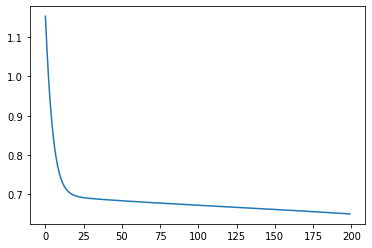

In [32]:
import torch
import torch.nn as nn

# 构建FF模型类
class XOR(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(XOR, self).__init__()
        self.w1 = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.b1 = nn.Parameter(torch.rand(hidden_dim, 1))
        self.w2 = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.b2 = nn.Parameter(torch.rand(output_dim, 1))

    def forward(self, x):

        n = x.shape[0]  # 样本量
        onevect = torch.ones(size=(n,)).view(n,1)

        z1 = torch.matmul(x,self.w1) + torch.matmul(onevect,self.b1.t()) 
        a1 = softplus2(z1)
        z2 = torch.matmul(a1,self.w2) + torch.matmul(onevect,self.b2.t()) 
        a2 = sigmoid2(z2)

        return a2

# 实现网络
torch.random.manual_seed(123456)

model = XOR(input_dim=2, hidden_dim=3, output_dim=1)
# print(list(model.parameters()))

# 初始化训练

from tqdm import tqdm

nepoch = 200 # 迭代次数
learning_rate = 0.1 # 学习率，即步长
losses = [] # 记录损失函数值

opt = torch.optim.SGD(model.parameters(), lr=learning_rate) # pytorch提供了一个优化器，对于model这个对象里的所有para进行优化

# 开始训练
pbar = tqdm(range(nepoch))
for i in pbar:
    a2 = model(x)
    loss = -torch.mean(y * torch.log(a2) + (1.0 - y) * torch.log(1.0 - a2))

    opt.zero_grad() # 梯度清零
    loss.backward() # 反向传播
    opt.step() 

    losses.append(loss.item())

    pbar.set_description("loss: %s" % loss.item())

# print(a2)

# 绘制损失函数训练图
import matplotlib.pylab as plt
plt.plot(losses)

# 查看预测结果
# print(a2)
# print(y)